In [11]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt


### Data Loader

In [85]:
trainfile = pd.read_csv('digit-recognizer/train.csv')
trainimg = [(np.reshape(row[1].values[1:],(28,28)),row[1].values[0]) for row in trainfile.iterrows()]

In [65]:
trainfile

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
def reshape(imgdata: pd.DataFrame()):
    img_reshaped = np.reshape(imgdata.values,(28,28))
    
    return img_reshaped

def drawimg(img):
    plt.title(f'Label: {img[1]}')
    plt.imshow(img[0])



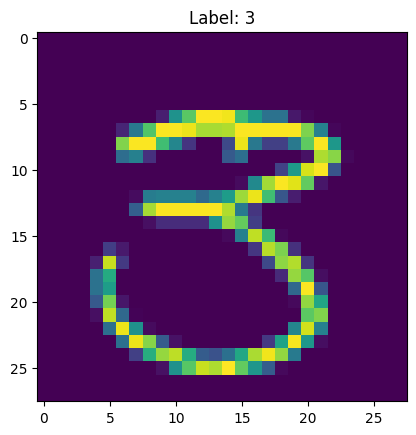

In [87]:
drawimg(trainimg[7])

In [88]:
class DigitDataset(Dataset):
    def __init__(self, img_dir):
        self.img_labels = pd.read_csv(img_dir)['label']
        self.img_dir = img_dir
        self.img = [np.reshape(row[1].values[1:],(28,28)) for row in pd.read_csv(img_dir).iterrows()]
        # self.transform = transform
        # self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self,idx):
        image = self.img[idx]
        label = self.img_labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image, label

In [89]:
ds = DigitDataset('digit-recognizer/train.csv')

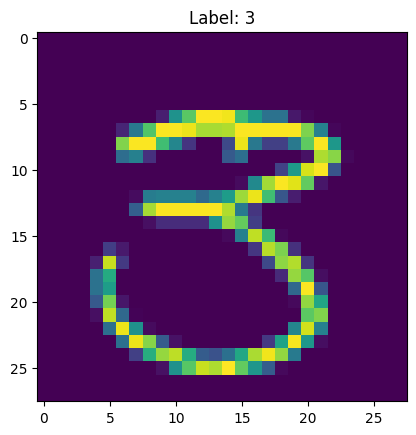

In [90]:
drawimg(ds[7])